For run this code, you must be installed the PandExo package and the PandExo data.  Pleas follow the instructions in the [PandExo documentation](https://natashabatalha.github.io/PandExo/installation.html).

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi
import numpy as np
import os
import pandas as pd
import multirex as mrex

ModuleNotFoundError: No module named 'pandexo'

### Generate spectra with only CO2

In [7]:
import multirex as mrex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [6]:
mrex.Util.get_gases()
mrex.Util.get_stellar_phoenix()
mrex.Util.list_gases()

The directory to the opacity database already exists in the specified path:  current directory
The directory to Phoenix already exists in the specified path:  current directory
Available gases in the database:
['DMS', 'CH4', 'O3', 'H2O', 'N2', 'CO', 'HCN', 'O2', 'CO2', 'C2H6', 'CH3Cl', 'NO2']


The directory to Phoenix already exists in the specified path:  current directory


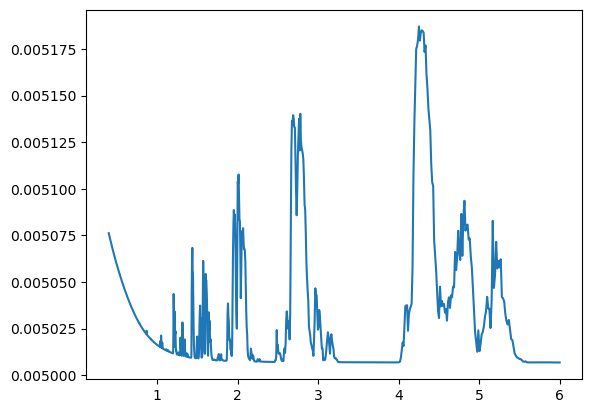

In [9]:
trappist1= mrex.Star(temperature=2566,radius=0.1192, mass=0.0898,phoenix_path="")
trappist1e= mrex.Planet(radius=0.920,mass=0.692)
# abiotic atmosphere
atm00= mrex.Atmosphere(temperature=287,base_pressure=1e5,
                           top_pressure=1e-3,composition={"CO2":-2},fill_gas="N2")

trappist1e.set_atmosphere(atm00)

sistema=mrex.System(planet=trappist1e,star=trappist1,
                    sma=0.02925)
sistema.make_tm()


# Seleccionar los elementos de la lista usando los índices
wn_grid=mrex.wavenumber_grid(0.4,6,1000)

_ , rp2_rs2 = sistema.generate_spectrum(wn_grid)

plt.plot(1e4/wn_grid,rp2_rs2)

## save 2 columns, wl and flux
np.savetxt("pandexo_spec.txt",np.array([1e4/wn_grid,rp2_rs2]).T)

## Creación de los instrumentos

In [10]:
exo_dict = jdi.load_exo_dict()
n_transits = 10

exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = n_transits #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 0.9535*3*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 0   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

Star data from NASA Exoplanet Archive

In [ ]:
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 11.354               #magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 2566             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H
exo_dict['star']['logg'] = 5.2396              #log surface gravity cgs

In [ ]:
exo_dict['planet']['type'] ='user'                       #tells pandexo you are uploading your own spectrum
exo_dict['planet']['exopath'] = 'pa_spec.txt'            #path to your spectrum
exo_dict['planet']['w_unit'] = 'um'                      #other options include "um","nm" ,"Angs", "sec" (for phase curves)
exo_dict['planet']['f_unit'] = 'rp^2/r*^2'               #other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.9535*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'                      #Any unit of time in accordance with astropy.units can be added

In [ ]:
## set NIRSpec Prism instrument

inst_dict=jdi.load_mode_dict('NIRSpec Prism')
inst_dict["configuration"]["detector"]["subarray"]="sub512"
inst_dict["configuration"]["detector"]["ngroup"] =6

In [ ]:
result = jdi.run_pandexo(exo_dict,inst_dict)

## plot the results
import matplotlib.pyplot as plt

import pandas as pd

## load spec2.txt
spec = pd.read_csv('pandexo_spec.txt', header=None, delimiter=' ')
spec

plt.figure(figsize=(20,12))
plt.errorbar(result["FinalSpectrum"]["wave"], result["FinalSpectrum"]["spectrum"], 
             yerr=result["FinalSpectrum"]["error_w_floor"], fmt='o', label='NIRSpec Prism'
            ,alpha=0.3)
plt.plot(spec[0], spec[1], label='Input',color='black')
plt.legend()

plt.ylim(0.00495, 0.00520)
plt.title(f'JWST PandExo Simulation\n {n_transits} transits ',fontsize=20)

## Evaluar evolución del Ruido

In [ ]:
observed=dict(
    NIRSpec_Prism=[],
)
n_obs=np.linspace(1,100,100)
from tqdm import tqdm
for n in tqdm(n_obs):
    exo_dict['observation']['noccultations'] = n
    result1 = jdi.run_pandexo(exo_dict,inst_dict)
    observed['NIRSpec_Prism'].append(result1["FinalSpectrum"])
    
plt.errorbar(observed['NIRSpec_Prism'][0]["wave"], observed['NIRSpec_Prism'][0]["spectrum"],
                yerr=observed['NIRSpec_Prism'][0]["error_w_floor"], fmt='o',
                label=f"{n_obs[0]} transits" ,alpha=0.3)
plt.errorbar(observed['NIRSpec_Prism'][4]["wave"], observed['NIRSpec_Prism'][4]["spectrum"],
             yerr=observed['NIRSpec_Prism'][4]["error_w_floor"], fmt='o',
             label=f"{n_obs[33]} transits" ,alpha=0.3)
plt.errorbar(observed['NIRSpec_Prism'][9]["wave"], observed['NIRSpec_Prism'][9]["spectrum"],
                yerr=observed['NIRSpec_Prism'][9]["error_w_floor"], fmt='o',
                label=f"{n_obs[66]} transits" ,alpha=0.3)
plt.errorbar(observed['NIRSpec_Prism'][-1]["wave"], observed['NIRSpec_Prism'][-1]["spectrum"],
             yerr=observed['NIRSpec_Prism'][-1]["error_w_floor"], fmt='o',
             label=f"{n_obs[-1]} transits" ,alpha=0.3)
             
#plt.xlim(0.6, 12)
plt.ylim(0.0049, 0.00555)
plt.legend()
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('$R_p^2/R_s^2$')


### SNR evolution

In [ ]:
## calculate SNR

## find idx where spec is max
idx = np.argmax(observed['NIRSpec_Prism'][0]["spectrum"])

## SNR is max value divided by the error
SNR=np.zeros(len(n_obs))
for i in range(len(n_obs)):
    idx = np.argmax(observed['NIRSpec_Prism'][i]["spectrum"])
    print(idx)
    print(observed['NIRSpec_Prism'][i]["spectrum"][idx])
    print(max(observed['NIRSpec_Prism'][i]["spectrum"]))
    signal = (max(observed['NIRSpec_Prism'][i]["spectrum"])-
              min(observed['NIRSpec_Prism'][i]["spectrum"]))
    SNR[i] = signal/observed['NIRSpec_Prism'][i]["error_w_floor"][idx]

## plot SNR vs n transits
plt.figure(figsize=(10,8))
plt.plot(n_obs, SNR, label='NIRSpec Prism')
plt.title(f'SNR on {observed["NIRSpec_Prism"][0]["wave"][idx]:.2f} $\mu m $ vs Number of Transits',fontsize=20)
plt.xlabel('Number of Transits')
plt.ylabel('SNR')
plt.legend()

## Plot the limist of RF detection for different SNR

In [ ]:
## calculate SNR

## find idx where spec is max
idx = np.argmax(observed['NIRSpec_Prism'][0]["spectrum"])

## SNR is max value divided by the error
SNR=np.zeros(len(n_obs))
for i in range(len(n_obs)):
    idx = np.argmax(observed['NIRSpec_Prism'][i]["spectrum"])
    print(idx)
    print(observed['NIRSpec_Prism'][i]["spectrum"][idx])
    print(max(observed['NIRSpec_Prism'][i]["spectrum"]))
    signal = (max(observed['NIRSpec_Prism'][i]["spectrum"])-
              min(observed['NIRSpec_Prism'][i]["spectrum"]))
    SNR[i] = signal/observed['NIRSpec_Prism'][i]["error_w_floor"][idx]


## plot SNR vs n transits
plt.figure(figsize=(10,8))
plt.plot(n_obs, SNR, label='NIRSpec Prism',color='black')
plt.axhline(3, color='#2874A6', linestyle='-.',
            label='MC $H_2O\; 10^{-4}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(5, color='#B7950B', linestyle='-.',
            label='MC $CH_4\; 10^{-6}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(6, color= "#B03A2E", linestyle='-.',
            label='MC $O_3\; 10^{-7}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(2,color='#2874A6', linestyle=':',
            label='SC $H_2O\; 10^{-4}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(3, color='#B7950B', linestyle=':',
            label='SC $CH_4\; 10^{-6}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(5, color= "#B03A2E", linestyle=':',
            label='SC $O_3\; 10^{-7}$ detection',
            alpha=0.7,linewidth=2.5)
plt.title(f'SNR on {observed["NIRSpec_Prism"][0]["wave"][idx]:.2f} $\mu m $ vs Number of Transits',
          fontsize=20)
plt.xlabel('Number of Transits')
plt.ylabel('SNR')
## x scale log with 10 ticks
plt.xscale('log')
plt.xticks([1,2,5,10,20,50,100])
plt.legend()
## show numbers on x axis
plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.legend()